In [1]:
import math
import numpy as np
import cv2
from dataclasses import dataclass, asdict

In [2]:
from ipynb.fs.full.CalibratedObserver import CalibratedCaptureConfiguration, CalibratedObserver, MiniMapObject

In [3]:
@dataclass
class HexGridConfiguration:
    size: float = 38
    rotation_deg: float = 0
    offset_xy: tuple = (0, 0)
    anchor_xy: tuple = (0, 0)
    width: int = 1600
    height: int = 1600

In [15]:
class HexCaptureConfiguration(CalibratedCaptureConfiguration):
    def loadConfiguration(self):
        super().loadConfiguration()
        config = self.readConfigFile()
        self.hex = config.get("hex", None)
        if self.hex is not None:
            self.hex = HexGridConfiguration(**self.hex)

    def buildConfiguration(self):
        config = super().buildConfiguration
        if self.hex is not None:
            config['hex'] = as_dict(self.hex)
        return config
    
    @staticmethod
    def axial_to_grid(q, r, size):
        x = size * math.sqrt(3) * (q + r/2)
        y = size * 1.5 * r

    @staticmethod
    def axial_to_pixel(q: float, r: float, size: float) -> np.ndarray:
        """
        Axial (q, r) → grid-space pixel (x, y), pointy-top hexes
        """
        x = size * math.sqrt(3) * (q + r / 2.0)
        y = size * 1.5 * r
        return np.array([x, y], dtype=np.float32)

    @staticmethod
    def axial_round(q: float, r: float) -> tuple[int, int]:
        """
        Round fractional axial coords to nearest hex
        """
        x = q
        z = r
        y = -x - z
    
        rx = round(x)
        ry = round(y)
        rz = round(z)
    
        dx = abs(rx - x)
        dy = abs(ry - y)
        dz = abs(rz - z)
    
        if dx > dy and dx > dz:
            rx = -ry - rz
        elif dy > dz:
            ry = -rx - rz
        else:
            rz = -rx - ry
    
        return int(rx), int(rz)

    @staticmethod
    def pixel_to_axial_frac(x: float, y: float, size: float) -> tuple[float, float]:
        """
        Grid-space pixel → fractional axial (q, r)
        """
        r = (2.0 / 3.0) * (y / size)
        q = (x / (math.sqrt(3) * size)) - (r / 2.0)
        return q, r
    
    def pixel_to_axial(
        self,
        px: float, py: float
    ) -> tuple[int, int]:
        """
        Image pixel → axial hex (q, r)
        """
        # Invert affine (2x3 → 3x3)
        M = self.make_affine_2x3()
        M3 = np.vstack([M, [0, 0, 1]])
        M_inv = np.linalg.inv(M3)
    
        pt = np.array([[px, py, 1.0]], dtype=np.float32).T
        gx, gy, _ = (M_inv @ pt).ravel()
    
        qf, rf = self.pixel_to_axial_frac(gx, gy, self.hex.size)
        return self.axial_round(qf, rf)

    def camCoordToAxial(self, cam, cam_coord: tuple[float]):
        real_coord = self.rsc.camCoordToRealSpace(cam, cam_coord)
        axial = self.pixel_to_axial(*real_coord)
        return axial

    def axialToCamCoord(self, cam, axial_coord: tuple[float]):
        real_coord = self.axial_to_pixel(*axial_coord, size=self.hex.size)
        return self.rsc.realSpaceToCamCoord(real_coord, cam)

    def changeSetToAxialCoord(self, changeSet):
        real_coord = self.rsc.changeSetToRealCenter(changeSet)
        return self.pixel_to_axial(*real_coord)

    @staticmethod
    def axial_distance(a: tuple[int, int], b: tuple[int, int] = (0, 0)) -> int:
        q1, r1 = a
        q2, r2 = b
        return (abs(q1 - q2)
              + abs(q1 + r1 - q2 - r2)
              + abs(r1 - r2)) // 2

    def trackedObjectLastDistance(self, trackedObject):
        if trackedObject.isNewObject:
            return 0
        previousChangeSet = trackedObject.previousVersion()
        current_axial = self.changeSetToAxialCoord(trackedObject)
        previous_axial = self.changeSetToAxialCoord(previousChangeSet)
        return self.axial_distance(current_axial, previous_axial)

    def make_affine_2x3(self) -> np.ndarray:
        ax, ay = self.hex.anchor_xy
        tx, ty = self.hex.offset_xy
        theta = math.radians(self.hex.rotation_deg)
        c = math.cos(theta)
        s = math.sin(theta)
    
        a11 = c
        a12 = -s
        a21 = s
        a22 = c
    
        # p' = A(p - anchor) + anchor + offset = A p + (anchor + offset - A anchor)
        b1 = ax + tx - (a11 * ax + a12 * ay)
        b2 = ay + ty - (a21 * ax + a22 * ay)
    
        return np.array([[a11, a12, b1],
                         [a21, a22, b2]], dtype=np.float32)

    def apply_affine_pts(self, pts_xy: np.ndarray) -> np.ndarray:
        """
        pts_xy: (N,2) float array
        returns: (N,2) float array
        """
        M = self.make_affine_2x3()
        x = pts_xy[:, 0]
        y = pts_xy[:, 1]
        xp = M[0, 0] * x + M[0, 1] * y + M[0, 2]
        yp = M[1, 0] * x + M[1, 1] * y + M[1, 2]
        return np.stack([xp, yp], axis=1)

    def hex_offsets_pointy(self) -> np.ndarray:
        """
        Corner offsets for a pointy-top hex centered at origin in *grid space*.
        Returns (6,2) float offsets.
        """
        offs = []
        for k in range(6):
            ang = math.radians(60 * k - 30)  # pointy-top
            offs.append([self.hex.size * math.cos(ang), self.hex.size * math.sin(ang)])
        return np.array(offs, dtype=np.float32),
    
    def draw_hex_grid_overlay(
        self,
        base_img: np.ndarray,
        x0: int, y0: int, w: int, h: int,
        *,
        color: tuple[int, int, int] = (255, 255, 255),
        thickness: int = 3,
        alpha: float = 1.0
    ) -> np.ndarray:
        """
        Draw a pointy-top hex grid over bbox [x0:x0+w, y0:y0+h] with
        scale/rotation/offset applied consistently to BOTH centers and corners.
        """
        overlay = self.draw_grid(color=color, thickness=thickness)
    
        # Blend only inside bbox
        out = base_img.copy()
        roi = out[y0:y0+h, x0:x0+w]
        roi_overlay = overlay[y0:y0+h, x0:x0+w]
        cv2.addWeighted(roi_overlay, alpha, roi, 1.0 - alpha, 0.0, dst=roi)
        out[y0:y0+h, x0:x0+w] = roi
        return out
        
    def draw_grid(
        self,
        color: tuple[int, int, int] = (80, 80, 80),
        thickness: int = 3
    ):
        overlay = np.zeros([self.hex.width, self.hex.height, 3], dtype="uint8")
    
        M = self.make_affine_2x3()
    
        # Proper center spacing for pointy-top hexes (in grid space)
        dx = math.sqrt(3) * self.hex.size
        dy = 1.5 * self.hex.size
    
        # Corner offsets in grid space (unscaled/unrotated; transform handles that)
        corner_offs = self.hex_offsets_pointy()
    
        pad = 4.0 * self.hex.size
        xmin_g = self.hex.anchor_xy[0] - pad
        xmax_g = self.hex.anchor_xy[0] + self.hex.width + pad
        ymin_g = self.hex.anchor_xy[1] - pad
        ymax_g = self.hex.anchor_xy[1] + self.hex.height + pad
    
        # Optionally: clip drawing to the bbox for speed by checking transformed centers
        row = 0
        cy_g = ymin_g
        while cy_g <= ymax_g:
            x_off = 0.0 if (row % 2 == 0) else (dx / 2.0)
            cx_g = xmin_g + x_off
            while cx_g <= xmax_g:
                center_g = np.array([[cx_g, cy_g]], dtype=np.float32)
                center_p = self.apply_affine_pts(center_g)[0]
    
                # quick reject if center way outside image
                if -200 <= center_p[0] <= self.hex.width + 200 and -200 <= center_p[1] <= self.hex.height + 200:
                    # Build hex polygon in grid space, then transform all corners
                    poly_g = corner_offs + center_g  # (6,2)
                    poly_p = self.apply_affine_pts(poly_g)  # (6,2)
    
                    poly_i = np.round(poly_p).astype(np.int32).reshape((-1, 1, 2))
                    cv2.polylines(
                        overlay, [poly_i], isClosed=True,
                        color=color, thickness=thickness,
                        lineType=cv2.LINE_AA
                    )
                    
                cx_g += dx
            cy_g += dy
            row += 1
        return overlay
    
    def buildMiniMap(self, objectsAndColors: list["MiniMapObject"], hex_cfg = None):
        image = self.draw_hex_grid_overlay(
            np.zeros([1200, 1200, 3], dtype="uint8"), 0, 0, 1200, 1200
        )
        if self.rsc is None:
            return image
    
        drawnObjs = []
        for objAndColor in objectsAndColors[::-1]:
            obj = objAndColor.object
            color = objAndColor.color
            if obj in drawnObjs:
                continue
            drawnObjs.append(obj)
            hull = self.objectToHull(obj)
            image = cv2.drawContours(image, [hull], -1, color, -1)
    
        return image

    def changeSetToAxial(self, changeSet):
        return self.pixel_to_axial(*self.rsc.changeSetToRealCenter(changeSet))

    def cameraGriddle(self, cam, objectsAndColors=[]):
        w, h = self.cameras[cam].mostRecentFrame.shape[:2]
        M = self.rsc.converters[cam][0].M
        Minv = np.linalg.inv(M)

        # Use nearest for crisp overlays; use linear for smoother images
        warped = cv2.warpPerspective(
            self.buildMiniMap(objectsAndColors=objectsAndColors),
            Minv,
            (h, w),
            flags=cv2.INTER_NEAREST,
            borderMode=cv2.BORDER_CONSTANT,
            borderValue=(0, 0, 0),
        )
        return warped[:w, :h]
        
    def griddleCameras(self, objectsAndColors=[], alpha=0.3):
        blended = {}
        img = self.buildMiniMap(objectsAndColors=objectsAndColors)
        for cam in self.cameras.keys():
            cameraChanges = self.cameras[cam].cropToActiveZone(self.cameras[cam].mostRecentFrame.copy())
            w, h = cameraChanges.shape[:2]
            M = self.rsc.converters[cam][0].M
            Minv = np.linalg.inv(M)
    
            # Use nearest for crisp overlays; use linear for smoother images
            warped = cv2.warpPerspective(
                img,
                Minv,
                (h, w),
                flags=cv2.INTER_NEAREST,
                borderMode=cv2.BORDER_CONSTANT,
                borderValue=(0, 0, 0),
            )
            blended[cam] = self.cameras[cam].cropToActiveZone(cv2.addWeighted(warped[:w, :h], alpha, cameraChanges, 1.0 - alpha, 0.0))
        return blended

    def axialDistanceBetweenObjects(self, changeSetA, changeSetB):
        real_coord_a = self.rsc.changeSetToRealCenter(changeSetA)
        real_coord_b = self.rsc.changeSetToRealCenter(changeSetB)
        axial_coord_a = self.pixel_to_axial(*real_coord_a)
        axial_coord_b = self.pixel_to_axial(*real_coord_b)
        return self.axial_distance(axial_coord_a, axial_coord_b)


Starting Cycle     0 -- CapMac -- passive idle


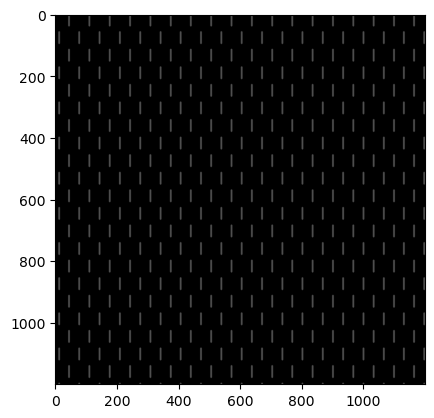

Starting Cycle     1 -- CapMac -- track idle
Starting Cycle     2 -- CapMac -- track idle
Starting Cycle     3 -- CapMac -- track idle
Starting Cycle     4 -- CapMac -- track idle
Starting Cycle     5 -- CapMac -- track idle
Starting Cycle     6 -- CapMac -- track idle
[0] attempt 1/5 failed: 
Starting Cycle     7 -- CapMac -- track idle
Starting Cycle     8 -- CapMac -- track idle
Starting Cycle     9 -- CapMac -- track idle
[0] attempt 1/5 failed: 
[0] attempt 2/5 failed: 
[0] attempt 3/5 failed: 
Starting Cycle    10 -- CapMac -- track idle
Starting Cycle    11 -- CapMac -- track idle
Starting Cycle    12 -- CapMac -- track idle
Starting Cycle    13 -- CapMac -- track idle
Starting Cycle    14 -- CapMac -- track idle
Starting Cycle    15 -- CapMac -- track idle
Starting Cycle    16 -- CapMac -- track idle
Starting Cycle    17 -- CapMac -- track idle
Starting Cycle    18 -- CapMac -- track idle
Starting Cycle    19 -- CapMac -- track idle
Starting Cycle    20 -- CapMac -- track idle


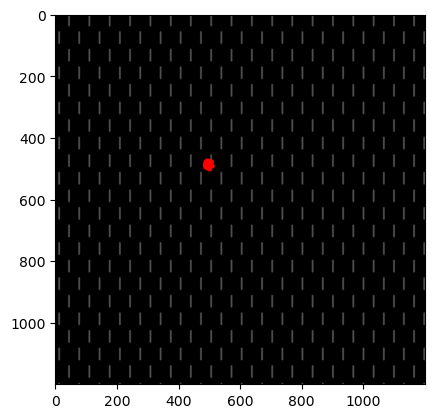

Starting Cycle   277 -- CapMac -- track idle
Starting Cycle   278 -- CapMac -- track unstable
Starting Cycle   279 -- CapMac -- track unstable
Overlap ratio is too low: 0.10383221128948732
Starting Cycle   280 -- CapMac -- track classify
Overlap ratio is too low: 0.10538581046090109
New Memory


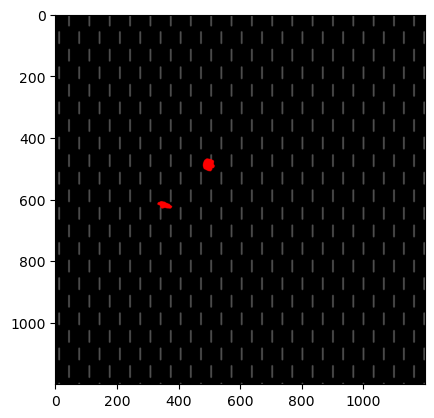

Axial Distance between objects: 1


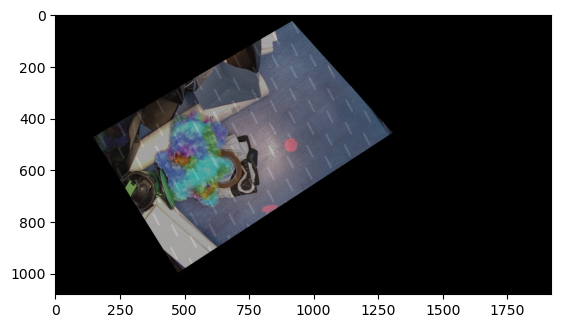

In [14]:
if __name__ == "__main__":
    import matplotlib.pyplot as plt 
    hc = HexCaptureConfiguration()
    hc.hex = HexGridConfiguration()
    co = CalibratedObserver(hc)
    co.cycle()
    plt.imshow(co.buildMiniMap(objectsAndColors=[MiniMapObject(mem, (255, 0, 0)) for mem in co.memory]))
    plt.show()
    for i in range(2):
        co.cycleForChange()
        plt.imshow(co.buildMiniMap(objectsAndColors=[MiniMapObject(mem, (255, 0, 0)) for mem in co.memory]))
        plt.show()
    a = hc.changeSetToAxial(co.memory[0])
    b = hc.changeSetToAxial(co.memory[1])
    print(f"Axial Distance between objects: {hc.axial_distance(a, b)}")
    plt.imshow(hc.griddleCameras(objectsAndColors=[MiniMapObject(mem, (255, 0, 0)) for mem in co.memory])['0'])